<a href="https://colab.research.google.com/github/Dolce-Latte/dnclab_study/blob/main/VGGnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌
import torch.nn.functional as F

import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 10

train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

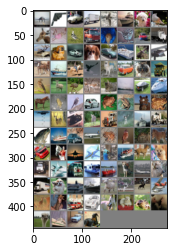

plane plane   car truck  bird  ship   dog  bird  deer   dog  bird truck   cat  bird   car truck  deer   dog   car   dog   car  ship  deer  ship horse  ship horse  bird   dog   car   cat truck  bird  deer  bird  deer   cat  ship   car  ship horse  frog  bird   car  frog  frog horse  frog plane  deer   cat  deer truck  deer  ship truck  frog  ship   car plane  frog  bird  frog horse   car horse plane plane  bird  ship horse   dog truck plane truck  ship  ship   dog plane  deer truck   dog  ship  ship horse horse horse plane  deer   cat truck   car   dog   dog  frog   cat  bird  ship   car   dog


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model


In [ ]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [ ]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [ ]:
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정|
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import torch.optim as optim

gpu_model = model


for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')

        optimizer.zero_grad()

        gpu_model = gpu_model.to('cuda')
        outputs = gpu_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        # epoch, num_epoch, i+1, len(train_loader),
        # loss.item()))
        running_loss += loss.item()
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,   500] loss: 1.061
[2,   500] loss: 0.899
[3,   500] loss: 0.774
[4,   500] loss: 0.617
[5,   500] loss: 0.507
[6,   500] loss: 0.422
[7,   500] loss: 0.364
[8,   500] loss: 0.306
[9,   500] loss: 0.262
[10,   500] loss: 0.221
Finished Training


In [ ]:
correct = 0
total = 0


for data in test_loader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 77 %


In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for data in test_loader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')

    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
    _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.5 %
Accuracy for class: car   is 84.3 %
Accuracy for class: bird  is 66.1 %
Accuracy for class: cat   is 60.8 %
Accuracy for class: deer  is 74.0 %
Accuracy for class: dog   is 69.9 %
Accuracy for class: frog  is 77.9 %
Accuracy for class: horse is 84.1 %
Accuracy for class: ship  is 87.0 %
Accuracy for class: truck is 91.1 %
